Customize the output plots
======================

In this tutorial we will show explicitly how to make the plots made by *wdwarfdate* and we are going to customize some. The goal of this tutorial is to provide code that is easy to modify to make our own versions of the plots.

In [1]:
import sys
sys.path.append('/Users/rociokiman/Documents/wdwarfdate')
import wdwarfdate  
import numpy as np
import time
import matplotlib.pyplot as plt
import corner

Then we set up the effective temperature and surface gravity that *wdwarfdate* needs to run. The values used in this tutorial are from Cummings, J.D. et al. 2018. We are going to add a list called `compasion` with the results of the parameter estimation from that paper too,

In [2]:
#Define data for the white dwarf
teffs = 19250
teffs_err = 500
loggs = 8.16
loggs_err = 0.084

comparison = [0.570 - 0.115, #Main sequence age
              0.115, # Cooling age (Gyr)
              0.570,# Total age
              2.99, # Initial mass
              0.717 # Final mass
              ]

In [3]:
start = time.time()
WD = wdwarfdate.WhiteDwarf(teffs,teffs_err,loggs,loggs_err,
                           model_wd='DA',feh='p0.00',vvcrit='0.0',
                           model_ifmr = 'Cummings_2018_MIST', 
                           high_perc = 84, low_perc = 16,
                           datatype='yr', 
                           save_plots=False, display_plots=False)
WD.calc_wd_age()
end = time.time()
print('{}m'.format((end - start)/60))

Running teff:19250 logg:8.16
0 steps out of 1000
Converged
17.790750567118327m


Now we are going to make each plot separately.

1) "results/teff_19250_logg_8.16_feh_p0.00_vvcrit_0.0_DA_Cummings_2018_MIST_walkers": traces for each walker to confirm convergence. 

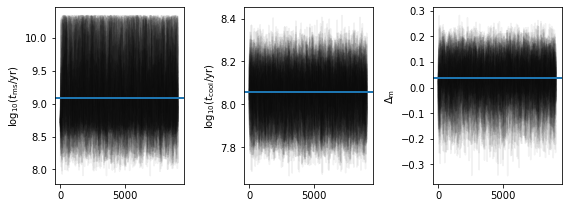

In [4]:
labels = [r'$\log_{10}(t_{\rm ms}/{\rm yr})$',
          r'$\log_{10}(t_{\rm cool}/{\rm yr})$', r'$\Delta_{\rm m}$']
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(8, 3))
for ax, j, label in zip([ax1, ax2, ax3], range(3), labels):
    for i in range(50):
        ax.plot(WD.chain[i, :, j], color='k', alpha=0.05)
        ax.axhline(y=np.median(WD.flat_samples[:, j]),
                   color='tab:blue')
    ax.set_ylabel(label)
plt.tight_layout()
plt.show()

2) "results/teff_19250_logg_8.16_feh_p0.00_vvcrit_0.0_DA_Cummings_2018_MIST_corner_plot.png": corner plot for the three independent variables: main sequence age, cooling age and delta m.

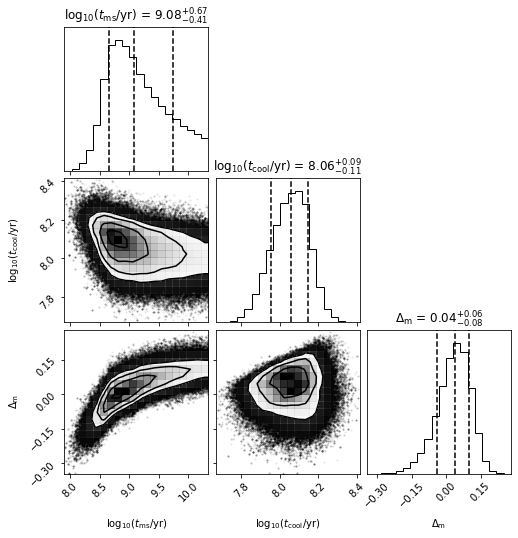

In [5]:
labels = [r'$\log_{10}(t_{\rm ms}/{\rm yr})$',
          r'$\log_{10}(t_{\rm cool}/{\rm yr})$', r'$\Delta _{\rm m}$']

fig = corner.corner(WD.flat_samples, labels=labels,
                    quantiles=[.16, .50, .84],
                    show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

3) "results/teff_19250_logg_8.16_feh_p0.00_vvcrit_0.0_DA_Cummings_2018_MIST_distributions.png": distribution of all the parameter of the white dwarf: the sampled parameters (main sequence and cooling age) and the dependent parameters (final mass, initial mass and total age).

For this plot we are going to add the comparison values as a red vertical line. We are also going to plot the results in Gyr, and not in yr. First we obtain the distributions from the code. 

In [6]:
ln_ms_age, ln_cooling_age, ln_total_age, initial_mass, final_mass = WD.get_distributions()

The default unit for the distributions of the three ages is $\log_{10}({\rm yr})$, so we are going to change it to Gyr.

In [7]:
res_ms_age = (10 ** ln_ms_age)/1e9
res_cool_age = (10 ** ln_cooling_age)/1e9 
res_tot_age = (10 ** ln_total_age)/1e9

Now we calculate the median, low and high percentiles again because we changed the units that we originally selected.

In [8]:
results = wdwarfdate.calc_percentiles(res_ms_age, res_cool_age, res_tot_age,
                                      initial_mass, final_mass,
                                      WD.high_perc, WD.low_perc)

And we have everything we need to plot the distributions.

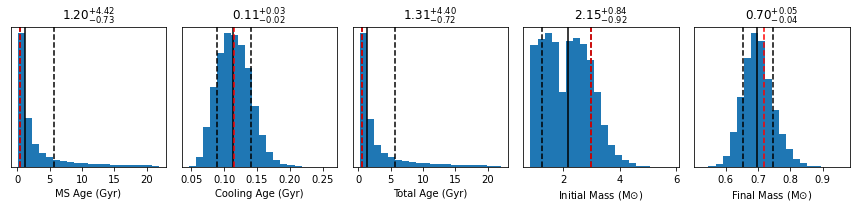

In [9]:
title = r"${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$"
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 3))

axs = [ax1, ax2, ax3, ax4, ax5]

labels = ['MS Age (Gyr)', 'Cooling Age (Gyr)', 'Total Age (Gyr)',
          r'Initial Mass (M$\odot$)', r'Final Mass (M$\odot$)']

distributions = [res_ms_age, res_cool_age, res_tot_age,initial_mass, final_mass]

for ax, label, dist, i, comparison_i in zip(axs, labels, distributions, np.arange(0, 15, 3), comparison):
    ax.hist(dist[~np.isnan(dist)], bins=20)
    ax.axvline(x=results[i], color='k')
    ax.axvline(x=results[i] - results[i+1], color='k', linestyle='--')
    ax.axvline(x=results[i] + results[i+2], color='k', linestyle='--')
    ax.axvline(x=comparison_i, color='r', linestyle='--')
    ax.set_xlabel(label)
    ax.yaxis.set_visible(False)
    ax.set_title(title.format(np.round(results[i], 2),
                              np.round(results[i+1], 2),
                              np.round(results[i+2], 2)))
plt.tight_layout()
plt.show()

4) "results/teff_19250_logg_8.16_feh_p0.00_vvcrit_0.0_DA_Cummings_2018_MIST_corr_time.png": result of the mean auto-correlation time for the three variables as explained in the tutorials for [autocorrelation time](https://emcee.readthedocs.io/en/stable/tutorials/autocorr/)  and [monitoring progress](https://emcee.readthedocs.io/en/stable/tutorials/monitor/) by Dan Foreman-Mackey.

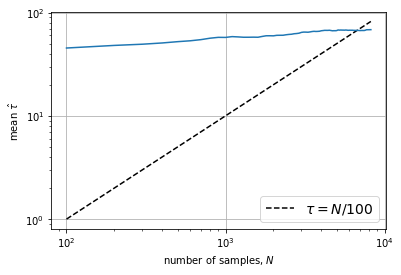

In [10]:
N = 100 * np.arange(1, WD.index_conv_i + 1)
plt.plot(N, N / 100.0, "--k", label=r"$\tau = N/100$")
plt.loglog(N, WD.autocorr_i[:WD.index_conv_i], "-")
plt.xlabel("number of samples, $N$")
plt.ylabel(r"mean $\hat{\tau}$")
plt.legend(fontsize=14)
plt.grid()
plt.show()

**Fast-test method**

We can do the same for the results from the fast-test method. In this case we need to set `return_distributions=True`, so we can plot the distributions after.

In [11]:
start = time.time()
WD_2 = wdwarfdate.WhiteDwarf(teffs,teffs_err,loggs,loggs_err,
                             method='fast_test',
                             model_wd='DA',feh='p0.00',vvcrit='0.0',
                             model_ifmr = 'Cummings_2018_MIST', 
                             high_perc = 84, low_perc = 16,
                             datatype='yr', return_distributions=True,
                             save_plots=False, display_plots=False)
WD_2.calc_wd_age()
end = time.time()
print('{}m'.format((end - start)/60))

0.006350398063659668m


In a similar way as before, we are going to transform the ages to Gyr. In this case the distributions are in yr. 

In [12]:
res_ms_age2 = np.array(WD_2.distributions[0])/1e9 # Main sequence age
res_cool_age2 = np.array(WD_2.distributions[1])/1e9 # Cooling age
res_tot_age2 = np.array(WD_2.distributions[2])/1e9 # Total age
initial_mass2 = np.array(WD_2.distributions[3])     # Initial mass
final_mass2 = np.array(WD_2.distributions[4])     # Final mass
results2 = wdwarfdate.calc_percentiles(res_ms_age2, res_cool_age2, res_tot_age2,
                                       initial_mass2, final_mass2,
                                       WD_2.high_perc, WD_2.low_perc)

Once we have the distributions, the plots work in the same way as above. We are going to add the comparisons in this plot too.

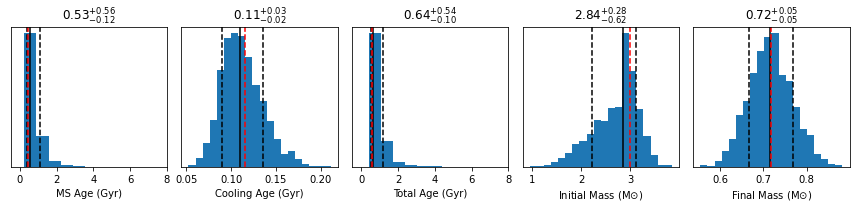

In [13]:
title = r"${{{0:.2f}}}_{{-{1:.2f}}}^{{+{2:.2f}}}$"
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(12, 3))

axs = [ax1, ax2, ax3, ax4, ax5]

labels = ['MS Age (Gyr)', 'Cooling Age (Gyr)', 'Total Age (Gyr)',
          r'Initial Mass (M$\odot$)', r'Final Mass (M$\odot$)']

distributions2 = [res_ms_age2, res_cool_age2, res_tot_age2,initial_mass2, final_mass2]

for ax, label, dist, i, comparison_i in zip(axs, labels, distributions2, np.arange(0, 15, 3), comparison):
    ax.hist(dist[~np.isnan(dist)], bins=20)
    ax.axvline(x=results2[i], color='k')
    ax.axvline(x=results2[i] - results2[i+1], color='k', linestyle='--')
    ax.axvline(x=results2[i] + results2[i+2], color='k', linestyle='--')
    ax.axvline(x=comparison_i, color='r', linestyle='--')
    ax.set_xlabel(label)
    ax.yaxis.set_visible(False)
    ax.set_title(title.format(np.round(results2[i], 2),
                              np.round(results2[i+1], 2),
                              np.round(results2[i+2], 2)))
ax1.set_xlim(-0.5,8)
ax3.set_xlim(-0.5,8)
plt.tight_layout()
plt.show()